In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import pandas as pd
import Swap_generators
import Strategy_helper

### Set of allowed moves for each agent
We will use the fermionic puzzle which is chosen arbitraily. The underlying particle structure does not meaningfully change the solving strategies to our knowledge.

In [2]:
Perms = Swap_generators.swaps(-1,-1)
SQRT_SWAP = Swap_generators.sqrt_swaps(-1,-1)
# Classical agent
CS = Perms

# Quantum agent's moves
QS = []
for move in SQRT_SWAP:
    QS.append(move)
    QS.append(np.transpose(np.conj(move)))
    
# Mixed agents moves 
MS = []
for move in SQRT_SWAP:
    MS.append(move)
    MS.append(np.transpose(np.conj(move)))
for move in Perms:
    MS.append(move)

## Scrambling
Scrambles are sqeunces of half swaps applied to the solved state. Here we generate a number of random scrambles with some constraintes on the minimum and maximum length of the scramble. 

In [3]:
## Generate a bunch of scrambles
Num_scrambles = 100
min_length = 200
max_length = 500
Scrambles = []
for i in range(Num_scrambles):
    l = random.randint(min_length,max_length)
    move_list = random.choices(QS,k=l)
    state = Swap_generators.zero
    for move in move_list:
        state = move @ state
    Scrambles.append(state)


# Rules

At first we will consider the situation in which the puzzle is reset after a measurement failure. After that we will consider a simplified version where each solver is only given one puzzle and only has one chance to measure it. 

## Finding performance of optimal strategy for reseting puzzle
The optimal strategy requires us to iterativly find all states that are up to $n$ moves away from the scrambled state. A target state is 1 move away from the scramble if a single actions from the solvers set of actions can transform the scrambled state into the target state. A state is 2 moves away from the scramble if the shortest possible set of actions from the solver to go between the scramble and target state is 2 moves.

Implementing this requires a breadth first search approach, that keeps track of which states have been seen and which have not. This search is implemented using a hashing of the state keeping 8 significant digits and canonicallizing the states. The optimal_search function then implements the search that will either continue until the optimal state is found, or some max_depth constraint is reached.

The function takes in a scramble a set of solving actions and optionally a set of costs for applying solving actions and measureing.

In [4]:
Costs = [1,1] # Swaps cost the same a measuring

In [ ]:
dataQ = Strategy_helper.Sample_scrambles_opt(Scrambles,QS,Costs)

In [ ]:
dataC = Strategy_helper.Sample_scrambles_opt(Scrambles,CS,Costs)

In [ ]:
dataM = Strategy_helper.Sample_scrambles_opt(Scrambles,MS,Costs)

In [8]:
dbfile = open('Data/QuantumOptimal_2000', 'ab')
     
pickle.dump(dataQ, dbfile) 
dbfile.close()
                  
dbfile = open('Data/ClassicalOptimal_2000', 'ab')
     
pickle.dump(dataC, dbfile) 
dbfile.close()

dbfile = open('Data/MixedOptimal_2000', 'ab')
     
pickle.dump(dataM, dbfile) 
dbfile.close()


### Analyzing the data
In the case where the puzzle is reset the number of moves until the puzzle is solved follows a gemoetric distribution. 
$$
N_\varphi = (M_\varphi+1)\text{Geo}(P_\varphi)
$$
where $M_\varphi$ is the distance from the scramble to the optimal state $\varphi$ and $P_\varphi$ is the squared overlap of the optimal state with the solved state $|\langle\varphi|\text{solved}\rangle|^2$.
In order to find the true performance of each solver we descretely sample the scramble space to build a distribution $Z(M,P)$ that describes how the parameters of the geometric distribution are distributied among random scrambles of the puzzle. We can finally define $G(n|M,P)$ to be the PDF that describes the distribution of the number of moves to solved $n$ given the scramble based parameters $M,P$.

In the limit of infinite sampling the the distribution of move count independent of scrambles becomes
$$
G(n) = \int_\Omega G(n|M,P) d\mu(\Omega(M,P)) = \sum_{M=1}^\infty \int_0^1 dP G(n|M,P)Z(M,P)
$$



In [17]:
dbfile = open('Data/QuantumOptimal_2000', 'rb')
     
dataQ = pickle.load(dbfile)
dbfile.close()
                  
dbfile = open('Data/ClassicalOptimal_2000', 'rb')
     
dataC = pickle.load(dbfile)
dbfile.close()

dbfile = open('Data/MixedOptimal_2000', 'rb')
     
dataM = pickle.load(dbfile)
dbfile.close()

In [18]:

depth = 7
Num_scrambles = len(dataQ[0])
Costs = [1,1]

ZQ,MQ,PQ = Strategy_helper.scramble_probabilities(dataQ,depth,Costs)#,Mvals=Mvals,Pvals=Pvals)
ZC,MC,PC = Strategy_helper.scramble_probabilities(dataC,depth,Costs)#,Mvals=Mvals,Pvals=Pvals)
ZM,MM,PM = Strategy_helper.scramble_probabilities(dataM,depth,Costs)#,Mvals=Mvals,Pvals=Pvals)
distQ = []
distC = []
distM = []
meanQ = 0
meanC = 0
meanM = 0

nvals = range(1,100)
for n in nvals:
    P_n_Q = Strategy_helper.Prob(n,MQ,PQ,ZQ)
    P_n_C = Strategy_helper.Prob(n,MC,PC,ZC)
    P_n_M = Strategy_helper.Prob(n,MM,PM,ZM)
    distQ.append(P_n_Q)
    distC.append(P_n_C)
    distM.append(P_n_M)
    meanQ += n*P_n_Q
    meanC += n*P_n_C
    meanM += n*P_n_M
print("Quantum solver average:",meanQ)
print("Classical solver average:",meanC)
print("Mixed solver average:",meanM)
assert(np.isclose(sum(distQ),1,rtol=1e-3))
assert(np.isclose(sum(distC),1,rtol=1e-3))
assert(np.isclose(sum(distM),1,rtol=1e-3))

Quantum solver average: 5.319085584992249
Classical solver average: 5.888426973768297
Mixed solver average: 4.776267452311938


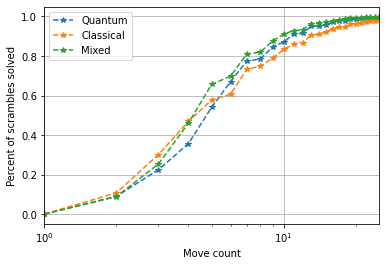

In [19]:
fig,ax = plt.subplots()
ax.semilogx(nvals,[sum(distQ[0:n]) for n in range(len(distQ))],'--*')
ax.semilogx(nvals,[sum(distC[0:n]) for n in range(len(distC))],'--*')
ax.semilogx(nvals,[sum(distM[0:n]) for n in range(len(distM))],'--*')
ax.set_xlim([1,25])
ax.legend(["Quantum","Classical",'Mixed'])
ax.set_ylabel("Percent of scrambles solved")
ax.set_xlabel("Move count")
ax.grid()
plt.savefig("./Figures/SolvingCDF.pdf",format="pdf")

## Scramble Parameter Distributions

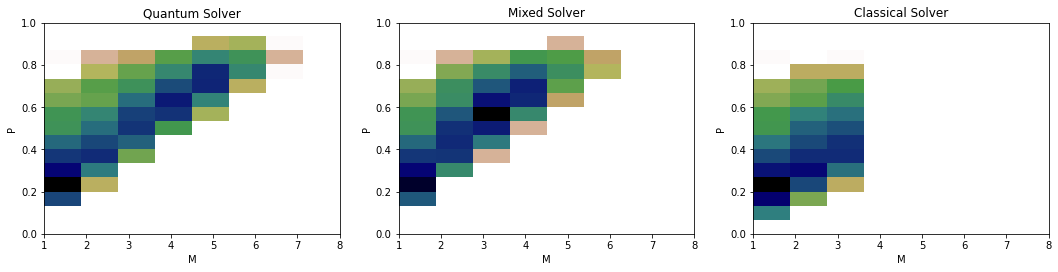

In [20]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].imshow(ZQ, cmap=plt.cm.gist_earth_r,
          extent=[1, depth+1, 0, 1],origin='lower',aspect = 5,norm=LogNorm())
ax[0].set_title('Quantum Solver')
ax[0].set_xlabel('M')
ax[0].set_ylabel('P')
ax[1].imshow(ZM, cmap=plt.cm.gist_earth_r,
          extent=[1, depth+1, 0, 1],origin='lower',aspect = 5,norm=LogNorm())
ax[1].set_title('Mixed Solver')
ax[1].set_xlabel('M')
ax[1].set_ylabel('P')
ax[2].imshow(ZC, cmap=plt.cm.gist_earth_r,
          extent=[1, depth+1, 0, 1],origin='lower',aspect = 5,norm=LogNorm())
ax[2].set_title('Classical Solver')
ax[2].set_xlabel('M')
ax[2].set_ylabel('P')
plt.show()

In [21]:
ZQ,EQ = Strategy_helper.scramble_expected_dist(dataQ)
ZC,EC = Strategy_helper.scramble_expected_dist(dataC)
ZM,EM = Strategy_helper.scramble_expected_dist(dataM)

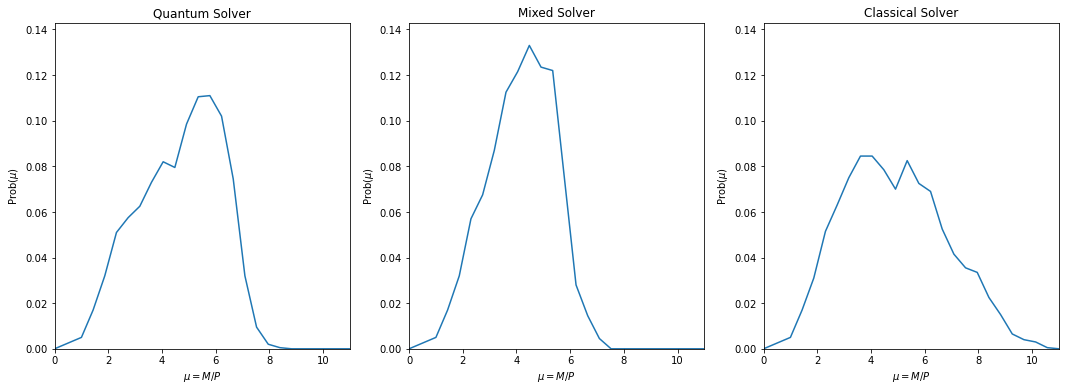

In [22]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].plot(EQ,ZQ)
ax[0].set_title('Quantum Solver')
ax[0].set_xlabel(r'$\mu = M/P$')
ax[0].set_ylabel(r'Prob($\mu$)')
ax[0].set_xlim([min(EC),max(EC)])
ax[0].set_ylim([0,max(ZM+.01)])
ax[1].plot(EM,ZM)
ax[1].set_title('Mixed Solver')
ax[1].set_xlabel(r'$\mu = M/P$')
ax[1].set_ylabel(r'Prob($\mu$)')
ax[1].set_xlim([min(EC),max(EC)])
ax[1].set_ylim([0,max(ZM)+.01])
ax[2].plot(EC,ZC)
ax[2].set_title('Classical Solver')
ax[2].set_xlabel(r'$\mu = M/P$')
ax[2].set_ylabel(r'Prob($\mu$)')
ax[2].set_xlim([min(EC),max(EC)])
ax[2].set_ylim([0,max(ZM)+.01])
plt.show()

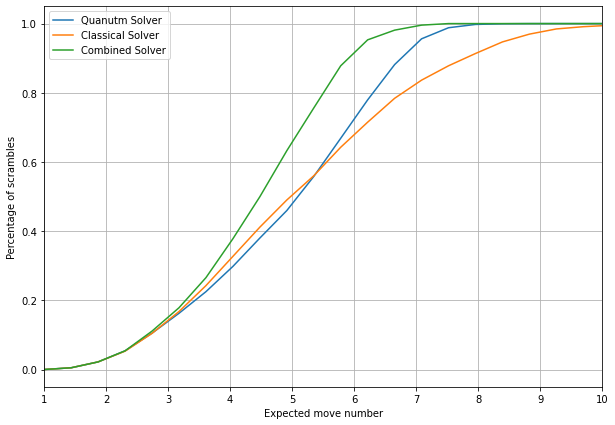

In [23]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(EQ,[sum(ZQ[0:n]) for n in range(len(ZQ))],'-')
ax.plot(EC,[sum(ZC[0:n]) for n in range(len(ZC))],'-')
ax.plot(EM,[sum(ZM[0:n]) for n in range(len(ZM))],'-')
ax.set_xlabel(r'Expected move number')
ax.set_ylabel(r'Percentage of scrambles')
ax.legend(['Quanutm Solver', 'Classical Solver', 'Combined Solver'])
ax.set_xlim([1,10])
ax.grid()
plt.savefig("./Figures/Expected_CDF.pdf",format="pdf")